In [1]:
# @title Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
import hashlib
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score, adjusted_rand_score
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.neighbors import NearestNeighbors


# Set seed for reproducibility
SEED = 47
np.random.seed(SEED)
random.seed(SEED)

In [2]:
# @title Load & Preprocess Data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')

In [3]:
# @title Data Engineering
# Load the data again since it was redefined previously
df = pd.read_csv('marketing_campaign.csv', sep='\t')

print("Number of unique values in Z_CostContact column:", df['Z_CostContact'].nunique())
print("Number of unique values in Z_Revenue column:", df["Z_Revenue"].nunique())

# Remove unnecessary columns ('Id' and columns with 1 unique value)
df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1, inplace=True)

# Standardize 'Marital_Status' into 2 broader groups
df['Marital_Status'] = df['Marital_Status'].replace(['Married', 'Together'], 'Partner')
df['Marital_Status'] = df['Marital_Status'].replace(['Divorced', 'Widow', 'Alone', 'YOLO', 'Absurd'], 'Single')

# Standardize 'Education' into 3 broader groups
df['Education'] = df['Education'].replace(['PhD', 'Master'], 'Postgraduate')
df['Education'] = df['Education'].replace(['2n Cycle', 'Graduation'], 'Graduate')
df['Education'] = df['Education'].replace(['Basic'], 'Undergraduate')

# Define categorical_columns here
categorical_columns = ['Education', 'Marital_Status']

for column in categorical_columns:
    print(f"Unique values in {column}:")
    print(df[column].unique())
    print("\n")

# Combining columns together to reduce the number of dimensions
df['Kids'] = df['Kidhome'] + df['Teenhome']
df['Expenses'] = df['MntWines'] + df['MntFruits'] + df['MntMeatProducts'] + df['MntFishProducts'] + df['MntSweetProducts'] + df['MntGoldProds']
df['TotalAcceptedCmp'] = df['AcceptedCmp1'] + df['AcceptedCmp2'] + df['AcceptedCmp3'] + df['AcceptedCmp4'] + df['AcceptedCmp5']
df['TotalNumPurchases'] = df['NumWebPurchases'] + df['NumCatalogPurchases'] + df['NumStorePurchases'] + df['NumDealsPurchases']

# Converting date to numerical variable by calculating duration
data = df.copy()

# Calculate 'Days_as_client' before selecting columns
df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
latest_date = df['Dt_Customer'].max()
df['Days_as_client'] = (latest_date - df['Dt_Customer']).dt.days
df.head()

df = df[['Education', 'Marital_Status', 'Income', 'Kids', 'Days_as_client', 'Recency', 'Expenses',
         'TotalNumPurchases', 'TotalAcceptedCmp', 'Complain', 'Response']]



Number of unique values in Z_CostContact column: 1
Number of unique values in Z_Revenue column: 1
Unique values in Education:
['Graduate' 'Postgraduate' 'Undergraduate']


Unique values in Marital_Status:
['Single' 'Partner']




In [4]:
# @title Clean data
def load_and_preprocess():
    # Load data
    df = pd.read_csv('marketing_campaign.csv', sep='\t')
    df = df.drop(['ID', 'Z_CostContact', 'Z_Revenue'], axis=1)
    df['Income'] = df['Income'].fillna(df['Income'].median())
    df['Dt_Customer'] = pd.to_datetime(df['Dt_Customer'], format='%d-%m-%Y')
    latest_date = df['Dt_Customer'].max()
    df['Tenure'] = (latest_date - df['Dt_Customer']).dt.days
    df = df.drop('Dt_Customer', axis=1)

    # One-Hot Encoding
    return pd.get_dummies(df, columns=['Education', 'Marital_Status'])

df = load_and_preprocess()

# Categorize columns into three groups based on their data type

binary_columns = [col for col in df.columns if df[col].nunique() == 2]
categorical_columns = [col for col in df.columns if 2 < df[col].nunique() < 10]
numerical_columns = [col for col in df.select_dtypes(include=['number']).columns
                     if col not in binary_columns + categorical_columns]


In [5]:
# @title Remove missing data and outliers

import numpy as np
# Remove missing values
df = df.dropna()

# Remove outliers using IQR method
def remove_outliers_iqr(df, columns):
    for col in columns:
        Q1 = df[col].quantile(0.25)
        Q3 = df[col].quantile(0.75)
        IQR = Q3 - Q1
        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
        df = df[(df[col] >= lower_bound) & (df[col] <= upper_bound)]
    return df

numerical_cols = df.select_dtypes(include=np.number).columns
df = remove_outliers_iqr(df, numerical_cols)


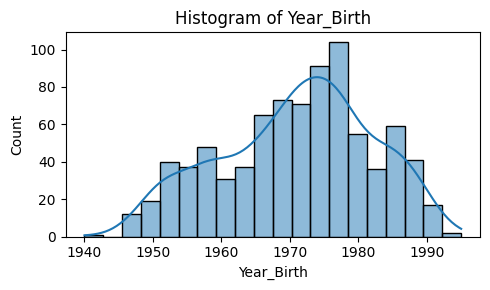

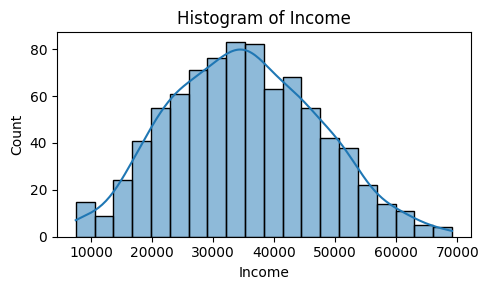

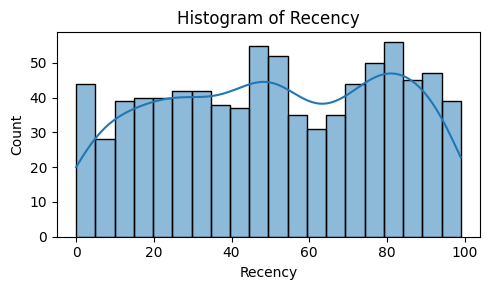

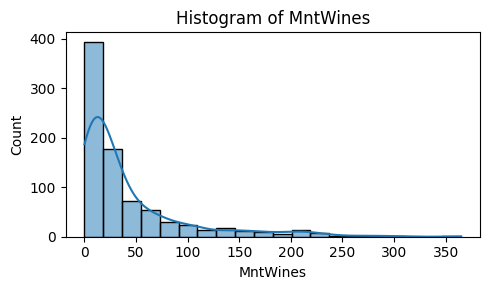

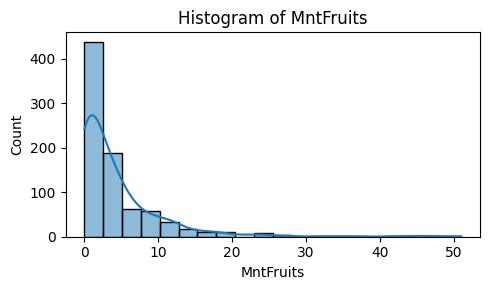

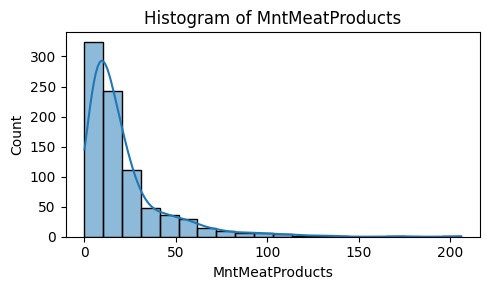

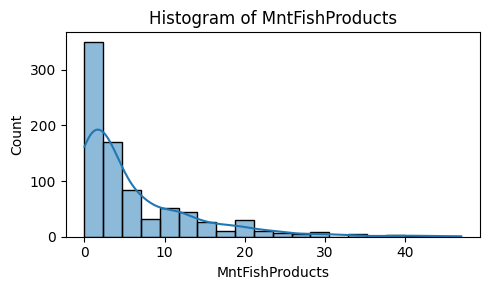

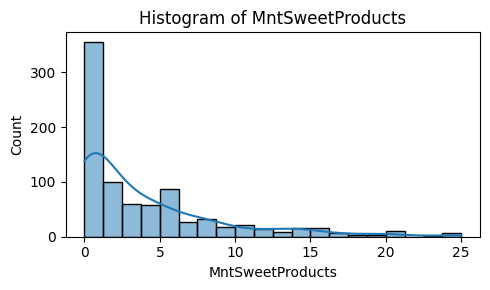

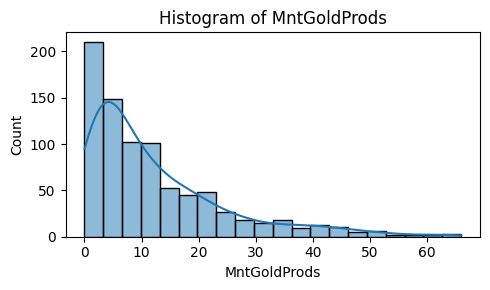

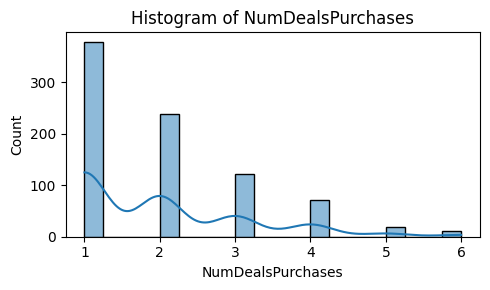

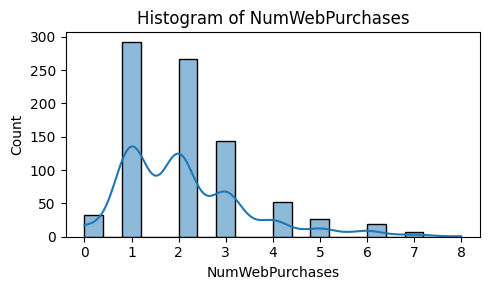

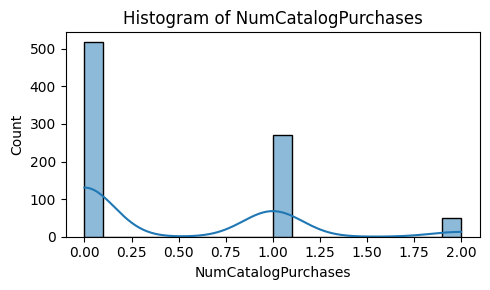

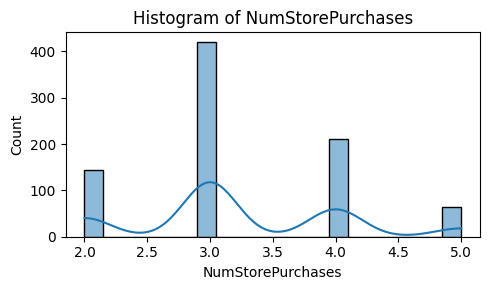

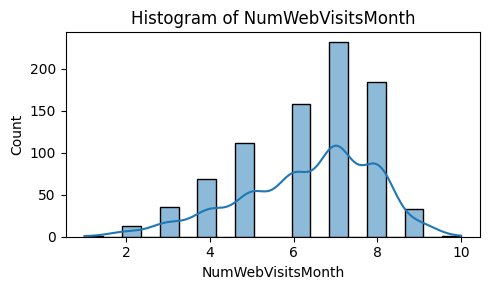

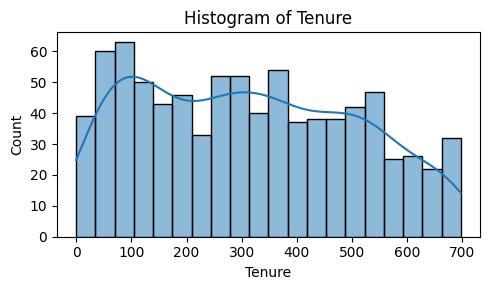

In [6]:
# @title Exploratory Data Analysis

# Plot histograms for each numerical column
for column in numerical_columns:

    plt.figure(figsize=(5, 3))
    sns.histplot(data=df, x=column, kde=True, bins=20)
    plt.title(f'Histogram of {column}')

    plt.tight_layout()
    plt.show()



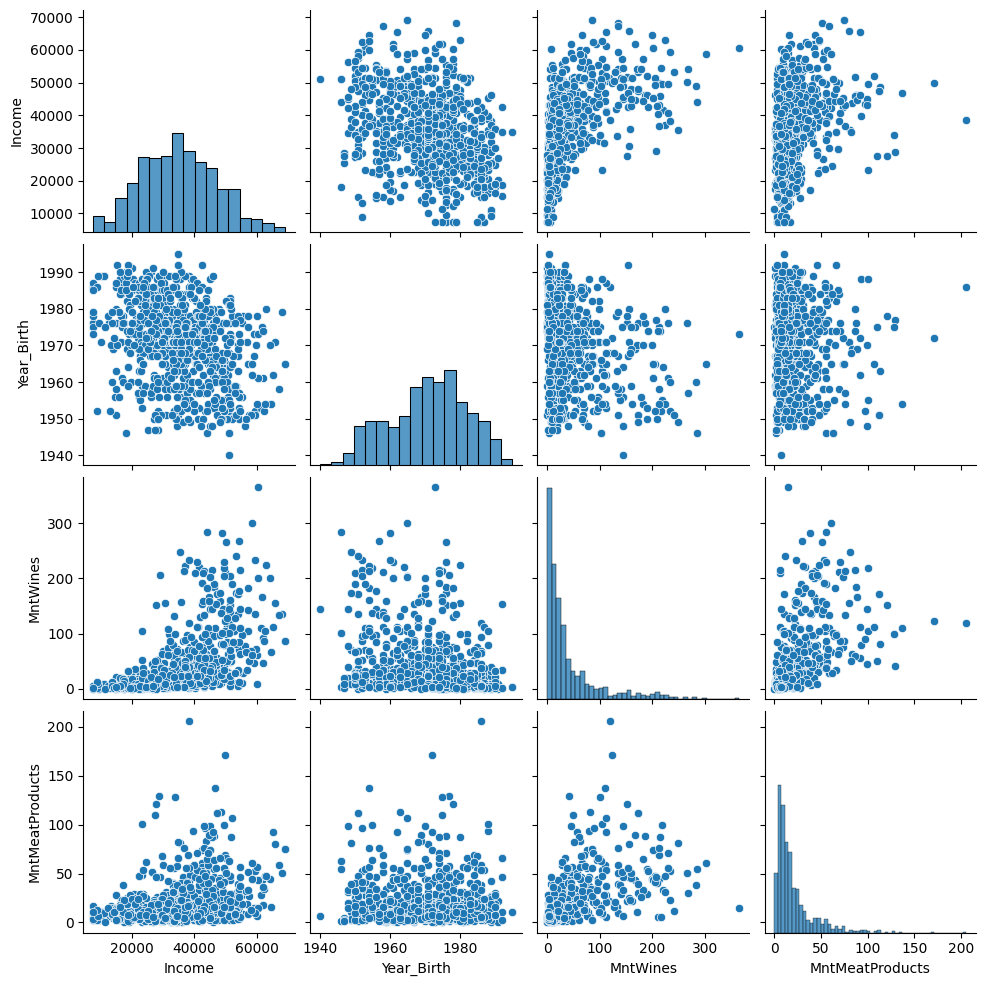

In [7]:

# @title Visualize relationships between multiple variables

sns.pairplot(df[['Income', 'Year_Birth', 'MntWines', 'MntMeatProducts']])
plt.show()


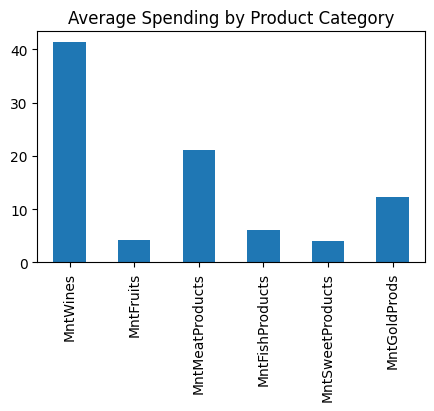

In [8]:

# @title Average Spending by Product Category
# Spending Patterns
spending_cols = ['MntWines', 'MntFruits', 'MntMeatProducts', 'MntFishProducts', 'MntSweetProducts', 'MntGoldProds']
plt.figure(figsize=(5, 3))
df[spending_cols].mean().plot(kind='bar')
plt.title('Average Spending by Product Category')
plt.show()



In [9]:
# @title Feature Scaling
scaler = StandardScaler()
scaled_data = scaler.fit_transform(df)
scaled_df = pd.DataFrame(scaled_data, columns=df.columns)

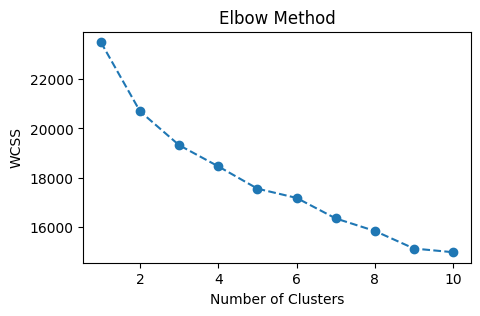

In [10]:
# @title Optimal Cluster Determination with Elbow Method
wcss = []
for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', random_state=42)
    kmeans.fit(scaled_df)
    wcss.append(kmeans.inertia_)

plt.figure(figsize=(5, 3))
plt.plot(range(1, 11), wcss, marker='o', linestyle='--')
plt.title('Elbow Method')
plt.xlabel('Number of Clusters')
plt.ylabel('WCSS')
plt.show()

In [11]:
# @title Fine tuning

import numpy as np
# @title Fine-tuning Clustering Algorithms
def fine_tune_kmeans(scaled_df):
    """Fine-tunes KMeans clustering."""
    best_score = -1
    best_kmeans = None
    for n_clusters in range(3, 6):  # Try different numbers of clusters
        for init in ['k-means++', 'random']:  # Try different initialization methods
            for max_iter in [300, 500]:  # Try different maximum iterations
                kmeans = KMeans(n_clusters=n_clusters, init=init, max_iter=max_iter, random_state=SEED)
                kmeans_labels = kmeans.fit_predict(scaled_df)
                silhouette_avg = silhouette_score(scaled_df, kmeans_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_kmeans = kmeans
    return best_kmeans

def fine_tune_dbscan(scaled_df):
    """Fine-tunes DBSCAN clustering."""
    best_score = -1
    best_dbscan = None
    for eps in np.linspace(0.5, 5, 10):  # Try different epsilon values
        for min_samples in range(5, 15):  # Try different minimum samples
            dbscan = DBSCAN(eps=eps, min_samples=min_samples)
            dbscan_labels = dbscan.fit_predict(scaled_df)
            if len(set(dbscan_labels)) > 1:  # Ensure more than one cluster is found
                silhouette_avg = silhouette_score(scaled_df, dbscan_labels)
                if silhouette_avg > best_score:
                    best_score = silhouette_avg
                    best_dbscan = dbscan
    return best_dbscan

def fine_tune_hierarchical(scaled_df):
    """Fine-tunes Hierarchical clustering."""
    best_score = -1
    best_agg = None
    for n_clusters in range(3, 6):  # Try different numbers of clusters
        for linkage in ['ward', 'complete', 'average']:  # Try different linkage methods
            agg = AgglomerativeClustering(n_clusters=n_clusters, linkage=linkage)
            agg_labels = agg.fit_predict(scaled_df)
            silhouette_avg = silhouette_score(scaled_df, agg_labels)
            if silhouette_avg > best_score:
                best_score = silhouette_avg
                best_agg = agg
    return best_agg


# Fine-tune the clustering algorithms
best_kmeans = fine_tune_kmeans(scaled_df)
best_dbscan = fine_tune_dbscan(scaled_df)
best_agg = fine_tune_hierarchical(scaled_df)

# Use the best models for clustering
kmeans_labels = best_kmeans.fit_predict(scaled_df)
dbscan_labels = best_dbscan.fit_predict(scaled_df)
agg_labels = best_agg.fit_predict(scaled_df)

# Evaluate and analyze the results of the fine-tuned models
print("KMeans Silhouette Score:", silhouette_score(scaled_df, kmeans_labels))
print("DBSCAN Silhouette Score:", silhouette_score(scaled_df, dbscan_labels))
print("Hierarchical Silhouette Score:", silhouette_score(scaled_df, agg_labels))

KMeans Silhouette Score: 0.11378786516596352
DBSCAN Silhouette Score: 0.1783847553161504
Hierarchical Silhouette Score: 0.3322131256383399


In [12]:
# @title Cluster Characterization (Fine-Tuned Models)
def characterize_clusters_tuned(labels, method_name, scaled_df):
    df[f'{method_name}_Cluster'] = labels
    # Select only numeric columns for the mean calculation
    numeric_cols = df.select_dtypes(include=np.number).columns
    cluster_profile = df.groupby(f'{method_name}_Cluster')[numeric_cols].mean()
    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])
    return cluster_profile

# Characterize fine-tuned models
characterize_clusters_tuned(kmeans_labels, 'kmeans_tuned', scaled_df)
characterize_clusters_tuned(dbscan_labels, 'dbscan_tuned', scaled_df)
characterize_clusters_tuned(agg_labels, 'hierarchical_tuned', scaled_df)


Kmeans_tuned Cluster Profiles:
                            Income    MntWines  MntMeatProducts  \
kmeans_tuned_Cluster                                              
0                     38758.401460   43.583942        14.941606   
1                     22080.566667    8.033333        15.183333   
2                     36092.892857   32.000000        16.401786   
3                     31610.133578   18.063725        13.963235   
4                     47750.844262  141.221311        58.778689   

                      NumDealsPurchases  NumWebPurchases  
kmeans_tuned_Cluster                                      
0                              1.839416         1.861314  
1                              1.750000         1.900000  
2                              1.785714         1.803571  
3                              1.762255         1.625000  
4                              3.196721         4.327869  

Dbscan_tuned Cluster Profiles:
                            Income    MntWines  MntMe

,Year_Birth,Income,Kidhome,Teenhome,Recency,MntWines,MntFruits,MntMeatProducts,MntFishProducts,MntSweetProducts,...,AcceptedCmp4,AcceptedCmp5,AcceptedCmp1,AcceptedCmp2,Complain,Response,Tenure,kmeans_tuned_Cluster,dbscan_tuned_Cluster,hierarchical_tuned_Cluster
hierarchical_tuned_Cluster,,,,,,,,,,,,,,,,,,,,,
0,1970.916368,35073.548984,0.782557,0.494624,51.232975,41.373955,4.229391,21.07049,6.0454,3.9773,...,0.0,0.0,0.0,0.0,0.0,0.0,312.322581,2.379928,0.016726,0.0
1,1988.000000,34176.000000,1.000000,0.000000,12.000000,5.000000,7.000000,24.00000,19.0000,14.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,48.000000,3.000000,-1.000000,1.0
2,1986.000000,8940.000000,1.000000,0.000000,25.000000,1.000000,45.000000,3.00000,4.0000,6.0000,...,0.0,0.0,0.0,0.0,0.0,0.0,676.000000,1.000000,-1.000000,2.0


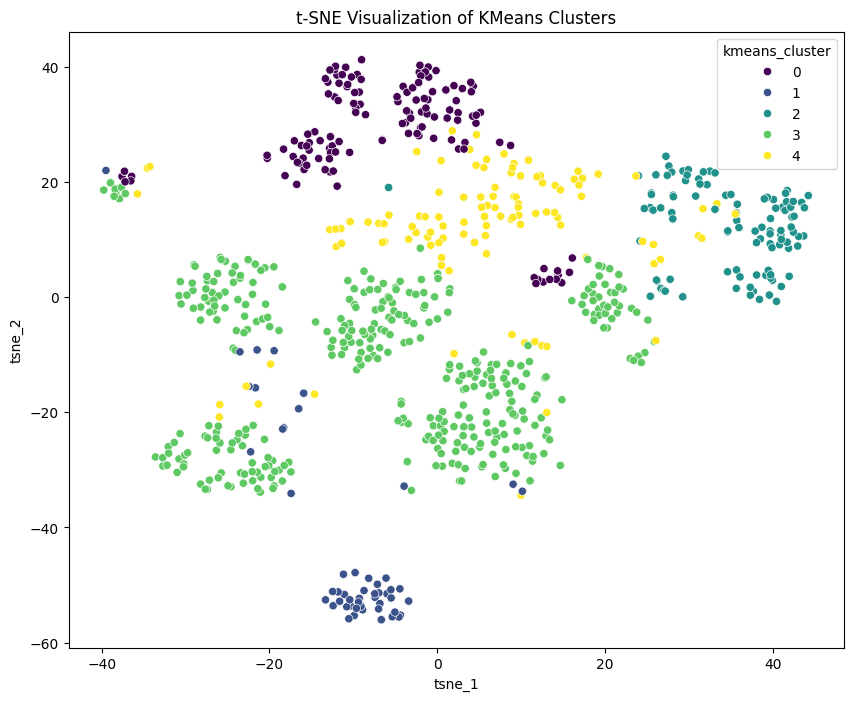

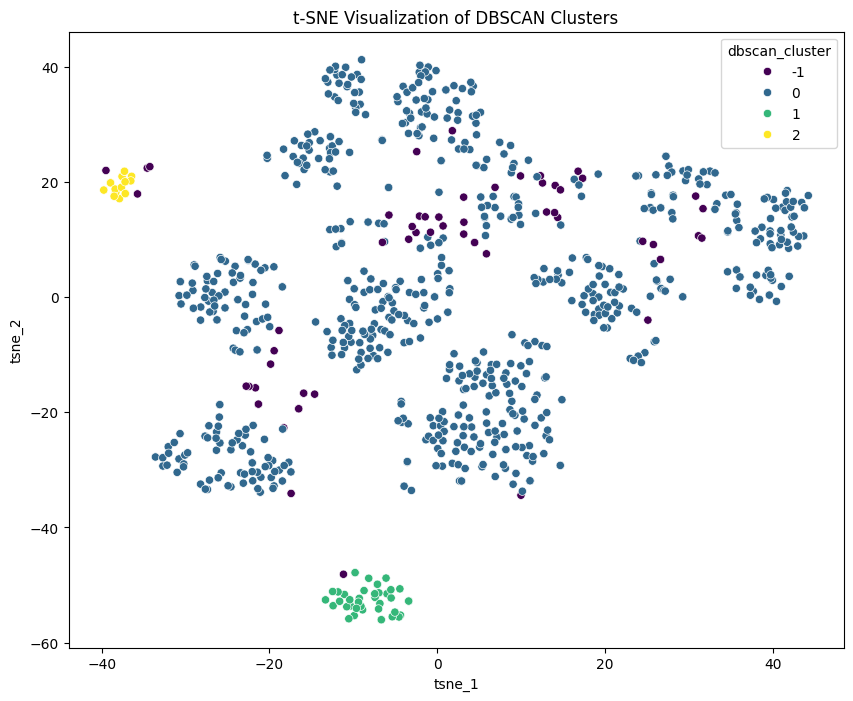

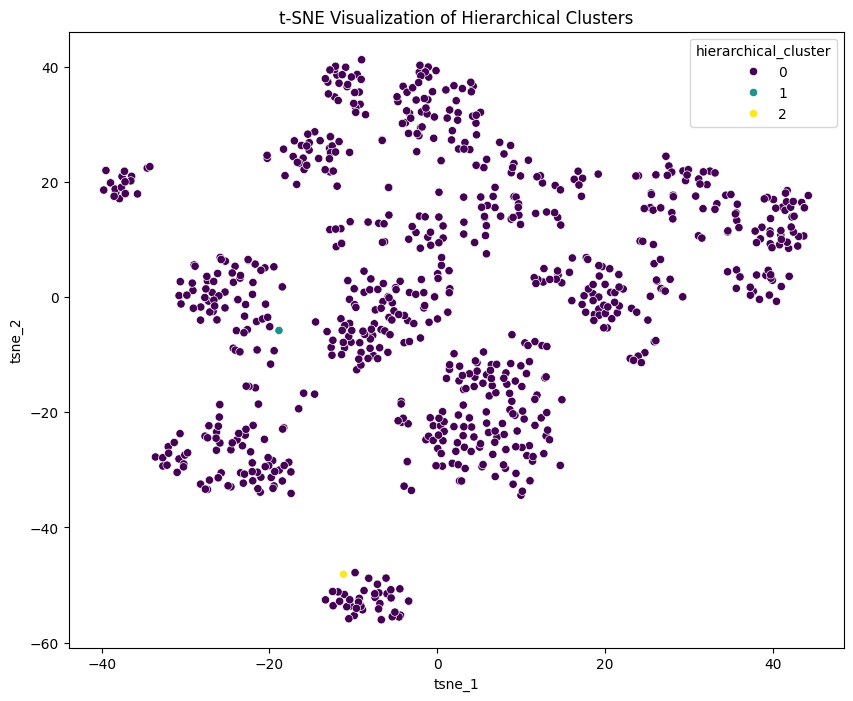

In [13]:
# @title TSNE for Fine-Tuned Models

import pandas as pd
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE

# Assuming 'scaled_df' contains your scaled data
# Perform t-SNE dimensionality reduction
tsne = TSNE(n_components=2, random_state=SEED)
tsne_results = tsne.fit_transform(scaled_df)

# Create a new DataFrame with the t-SNE results and cluster labels
tsne_df = pd.DataFrame({'tsne_1': tsne_results[:, 0], 'tsne_2': tsne_results[:, 1],
                       'kmeans_cluster': kmeans_labels, 'dbscan_cluster': dbscan_labels,
                       'hierarchical_cluster': agg_labels})

# Visualize the clusters in the t-SNE reduced space
plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='kmeans_cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE Visualization of KMeans Clusters')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='dbscan_cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE Visualization of DBSCAN Clusters')
plt.show()

plt.figure(figsize=(10, 8))
sns.scatterplot(x='tsne_1', y='tsne_2', hue='hierarchical_cluster', data=tsne_df, palette='viridis')
plt.title('t-SNE Visualization of Hierarchical Clusters')
plt.show()


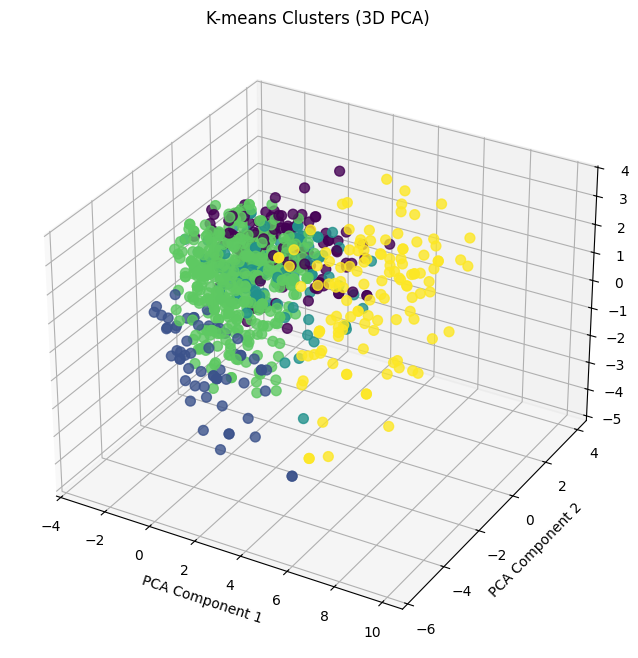

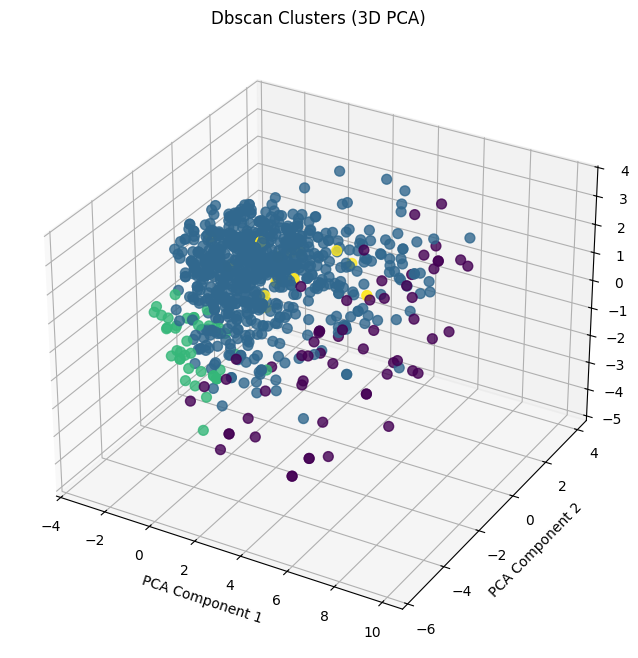

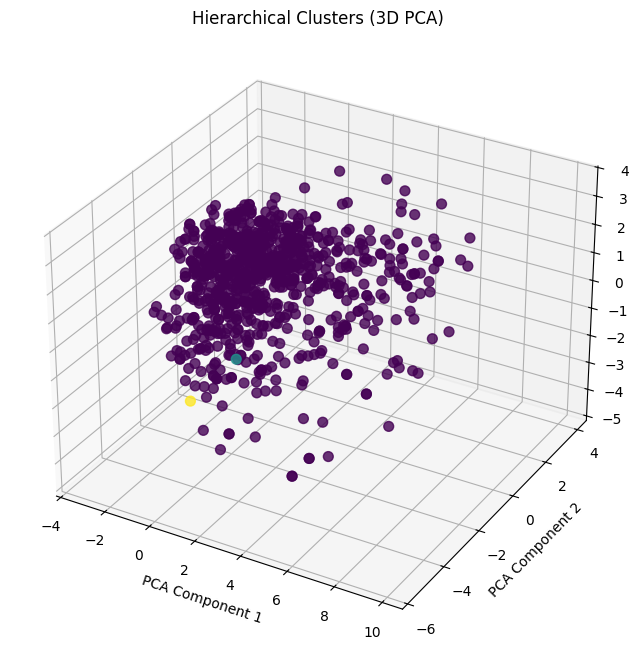

In [14]:
# @title 3D cluster visualization

import matplotlib.pyplot as plt
# Perform PCA with 3 components
pca = PCA(n_components=3)
principal_components = pca.fit_transform(scaled_df)

def plot_3d_clusters(labels, method_name):
    fig = plt.figure(figsize=(10, 8))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(principal_components[:, 0], principal_components[:, 1], principal_components[:, 2],
               c=labels, cmap='viridis', s=50, alpha=0.8)
    ax.set_title(f'{method_name.capitalize()} Clusters (3D PCA)')
    ax.set_xlabel('PCA Component 1')
    ax.set_ylabel('PCA Component 2')
    ax.set_zlabel('PCA Component 3')
    plt.show()


# Plot 3D visualizations for each clustering method
plot_3d_clusters(kmeans_labels, 'K-Means')
plot_3d_clusters(dbscan_labels, 'DBSCAN')
plot_3d_clusters(agg_labels, 'Hierarchical')


In [15]:
# @title Cluster Characterization

def characterize_clusters(labels, method_name):
    df[f'{method_name}_Cluster'] = labels
    # Exclude the cluster label column from the mean calculation
    cluster_profile = df.drop(columns=[col for col in df.columns if '_Label' in col]).groupby(f'{method_name}_Cluster').mean()

    print(f"\n{method_name.capitalize()} Cluster Profiles:")
    print(cluster_profile[['Income', 'MntWines', 'MntMeatProducts',
                          'NumDealsPurchases', 'NumWebPurchases']])

    # Removed the code that assigns cluster labels
    '''
    if method_name == 'kmeans':
        labels_map = {
            0: "High-Value Customers", #Big Spenders
            1: "Low-Value Customers", #Budget-Conscious Shoppers (4 cluster)"Premium Customers",
            2: "Deal Seekers",
            3: "Regular Shoppers"
        }
        df[f'{method_name}_Cluster_Label'] = df[f'{method_name}_Cluster'].map(labels_map)
    '''
    # Print Cluster Distributions:
    print(f"\n{method_name.capitalize()} Cluster Distributions:")
    print(df[f'{method_name}_Cluster'].value_counts())

    # Removed the code that prints cluster distribution labels
    '''
    if method_name == 'kmeans':
        print(f"\n{method_name.capitalize()} Cluster Distribution Labels:")
        print(df[f'{method_name}_Cluster_Label'].value_counts())
    '''
    return cluster_profile

# Define cluster_results before using it
# Assuming you have labels for 'kmeans', 'dbscan', and 'hierarchical' methods
cluster_results = {
    'kmeans': [kmeans_labels],  # Store labels for each method
    'dbscan': [dbscan_labels],
    'hierarchical': [agg_labels]  # Use agg_labels if you have them
}

# Characterize all methods
for method in cluster_results.keys():
    characterize_clusters(cluster_results[method][0], method)

    # Removed the code that prints cluster distribution labels
    '''
    if method == 'kmeans':
         print(f"\n{method.capitalize()} Cluster Distribution Labels:")
         print(df[f'{method}_Cluster_Label'].value_counts())
    '''


Kmeans Cluster Profiles:
                      Income    MntWines  MntMeatProducts  NumDealsPurchases  \
kmeans_Cluster                                                                 
0               38758.401460   43.583942        14.941606           1.839416   
1               22080.566667    8.033333        15.183333           1.750000   
2               36092.892857   32.000000        16.401786           1.785714   
3               31610.133578   18.063725        13.963235           1.762255   
4               47750.844262  141.221311        58.778689           3.196721   

                NumWebPurchases  
kmeans_Cluster                   
0                      1.861314  
1                      1.900000  
2                      1.803571  
3                      1.625000  
4                      4.327869  

Kmeans Cluster Distributions:
kmeans_Cluster
3    408
0    137
4    122
2    112
1     60
Name: count, dtype: int64

Dbscan Cluster Profiles:
                      Income    